In [1]:
# !pip install neuron
# !pip install netpyne
import matplotlib

In [14]:
# Cells: 3709

#   Connections: 73676 (19.86 per cell) ## seed 4321
#   Synaptic contacts: 106610 (28.74 per cell)
        #   Connections: 75254 (20.29 per cell) ## seed 1234
        #   Synaptic contacts: 108512 (29.26 per cell)

In [15]:
VPL_sTC = 656
VPM_sTC = 1495 - 656
POm_sTC_s1 = 2180 - 1495
ss_RTN_o = 2562 - 2180
ss_RTN_m = 2944 - 2562
ss_RTN_i = 3709 - 2944

In [16]:
print('VPL_sTC' , VPL_sTC)
print('VPM_sTC' , VPM_sTC)
print('POm_sTC_s1' , POm_sTC_s1)
print('ss_RTN_o' , ss_RTN_o)
print('ss_RTN_m' , ss_RTN_m)
print('ss_RTN_i', ss_RTN_i)

print('\n total Th', VPL_sTC + VPM_sTC + POm_sTC_s1 + ss_RTN_o + ss_RTN_m + ss_RTN_i)

VPL_sTC 656
VPM_sTC 839
POm_sTC_s1 685
ss_RTN_o 382
ss_RTN_m 382
ss_RTN_i 765

 total Th 3709


In [2]:
from netpyne import specs, sim
import numpy as np

# %matplotlib inline

# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 300.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 1378.8 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 300.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

layer = {'1':[0.0, 0.089], '2': [0.089,0.159], '3': [0.159,0.286], '23': [0.089,0.286], '4':[0.286,0.421], '5': [0.421,0.684], '6': [0.684,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries
#Th pop
ymin={'ss_RTN_o': 1688, 'ss_RTN_m': 1766, 'ss_RTN_i': 1844, 'VPL_sTC': 2000, 'VPM_sTC': 2156, 'POm_sTC_s1': 2312}
ymax={'ss_RTN_o': 1766, 'ss_RTN_m': 1844, 'ss_RTN_i': 2000, 'VPL_sTC': 2156, 'VPM_sTC': 2312, 'POm_sTC_s1': 2624}

## Cell params
secs = {}   # sections dict
secs['soma'] = {'geom': {}, 'mechs': {}}                                                    # soma params dict
secs['soma']['geom'] = {'diam': 18.8, 'L': 18.8}                                            # soma geometry
secs['soma']['mechs']['hh'] = {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.003, 'el': -70}      # soma hh mechanism
netParams.cellParams['PYR'] = {'secs': secs}                                                # add dict to list of cell params

VPMnumber = int(1.0*839.72)

## Population parameters
netParams.popParams['S'] = {'cellType': 'PYR', 'numCells': VPMnumber, 'cellModel': 'HH', 'yRange': [ymin['VPM_sTC'], ymax['VPM_sTC']]}
netParams.popParams['M'] = {'cellType': 'PYR', 'numCells': 312, 'cellModel': 'HH', 'ynormRange': layer['6']} # conv 131
netParams.popParams['M2'] = {'cellType': 'PYR', 'numCells': 754, 'cellModel': 'HH', 'ynormRange': layer['6']} # conv 131
netParams.popParams['I'] = {'cellType': 'PYR', 'numCells': 14, 'cellModel': 'HH', 'ynormRange': layer['6']} # conv 77
netParams.popParams['I2'] = {'cellType': 'PYR', 'numCells': 100, 'cellModel': 'HH', 'ynormRange': layer['6']} # conv 77

## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.1, 'tau2': 5.0, 'e': 0}  # excitatory synaptic mechanism

## Cell connectivity rules
synapsesperconnection_Th_S1 = 9.0
radius2D_Th_S1 = 50.0

for post in ['M', 'M2', 'I', 'I2']:
  if post[0] == 'M':
    conn_convergence = np.ceil(131/synapsesperconnection_Th_S1)
  else:
    conn_convergence = np.ceil(77/synapsesperconnection_Th_S1)

  prob_conv = 1.0*(conn_convergence/VPMnumber)*((150.0*150.0)/(radius2D_Th_S1*radius2D_Th_S1)) # prob*(AreaS1/Area_Th_syn)  
  probability_rule = '%f if dist_2D < %f else 0.0' % (prob_conv,radius2D_Th_S1)

  netParams.connParams['EE_S'+'_'+post] = { 
      'preConds': {'pop': 'S'}, 
      'postConds': {'pop': post},
      'probability': probability_rule, 
      'weight': 0.720,  
      'delay': 'defaultDelay+dist_3D/propVelocity',
      'synsPerConn': int(synapsesperconnection_Th_S1)}  

# Simulation options
simConfig = specs.SimConfig()       # object of class SimConfig to store simulation configuration

simConfig.duration = 1*1e3          # Duration of the simulation, in ms
simConfig.dt = 0.025                # Internal integration timestep to use
simConfig.verbose = False           # Show detailed messages
simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig.recordStep = 0.1          # Step size in ms to save data (eg. V traces, LFP, etc)
simConfig.filename = 'tut6'         # Set file output name
simConfig.savePickle = False        # Save params, network and sim output to pickle file

# simConfig.analysis['plotRaster'] = {'saveFig': True, 'markerSize': 50, 'orderBy':'y'}                                # Plot a raster
# simConfig.analysis['plotTraces'] = {'include': [('S',0), ('M',0)], 'saveFig': True}  # Plot recorded traces for this list of cells


# Create network and run simulation
# sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)




In [3]:
import numpy as np


 ###################### 

VPMpercent 15 radius2D_Th_S1 25

 ###################### 


Start time:  2021-06-15 13:51:43.064506

Creating network of 5 cell populations on 1 hosts...
  Number of cells on node 0: 1305 
  Done; cell creation time = 0.13 s.
Making connections...
  Number of connections on node 0: 3707 
  Number of synaptic contacts on node 0: 33363 
  Done; cell connection time = 2.07 s.

Gathering data...
  Done; gather time = 0.93 s.

Analyzing...
  Cells: 1305
  Connections: 3707 (2.84 per cell)
  Synaptic contacts: 33363 (25.57 per cell)
Plotting connectivity matrix...

 ###################### 

VPMpercent 15 radius2D_Th_S1 50

 ###################### 


Start time:  2021-06-15 13:51:46.607547

Creating network of 5 cell populations on 1 hosts...
  Number of cells on node 0: 1305 
  Done; cell creation time = 0.13 s.
Making connections...
  Number of connections on node 0: 13091 
  Number of synaptic contacts on node 0: 117819 
  Done; cell connection time = 4.86 s.

Ga

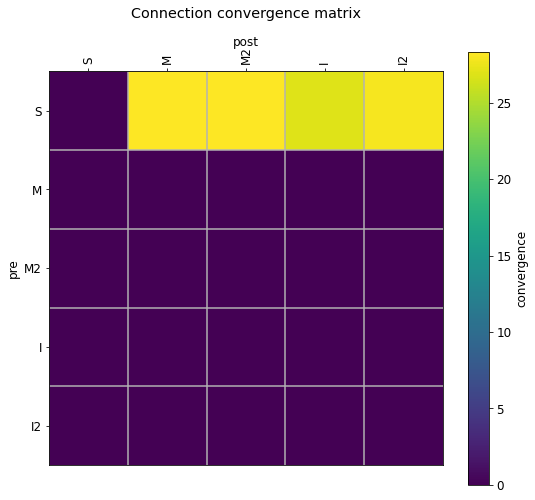

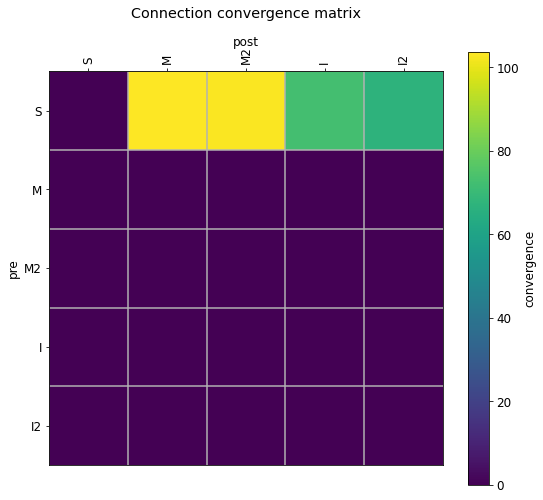

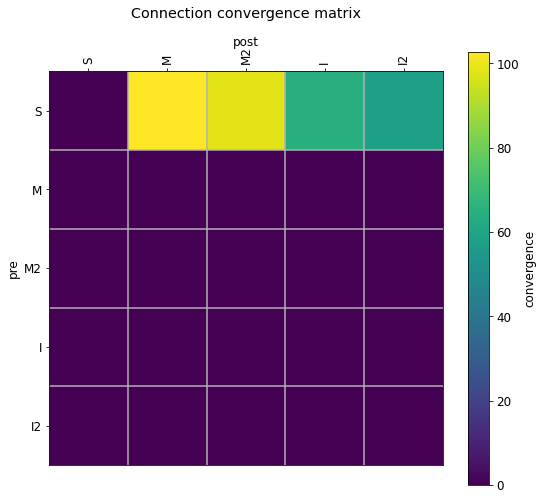

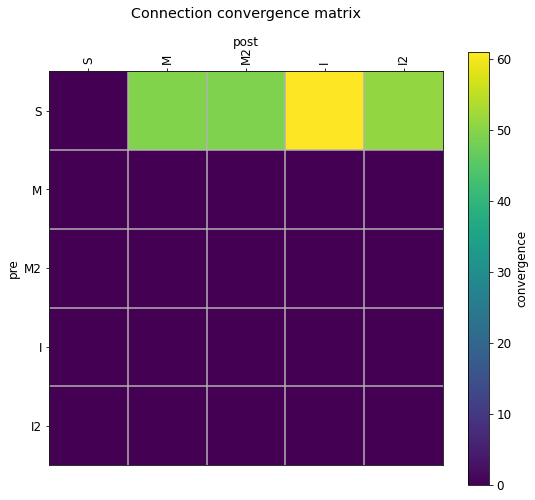

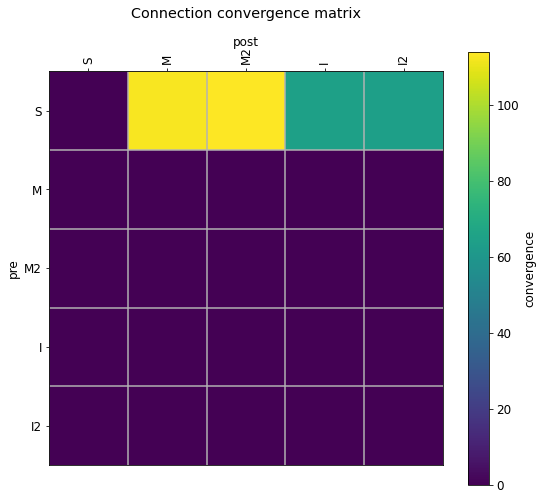

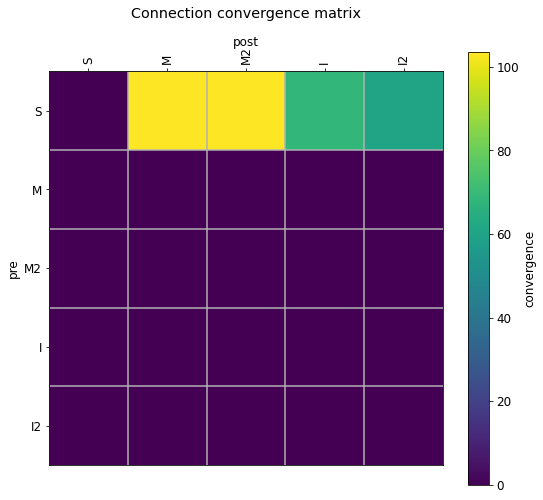

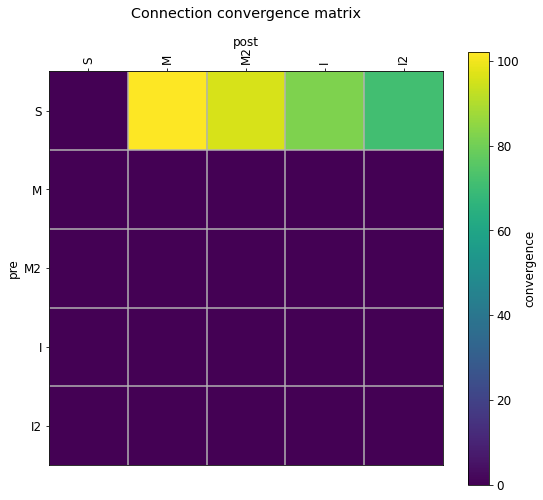

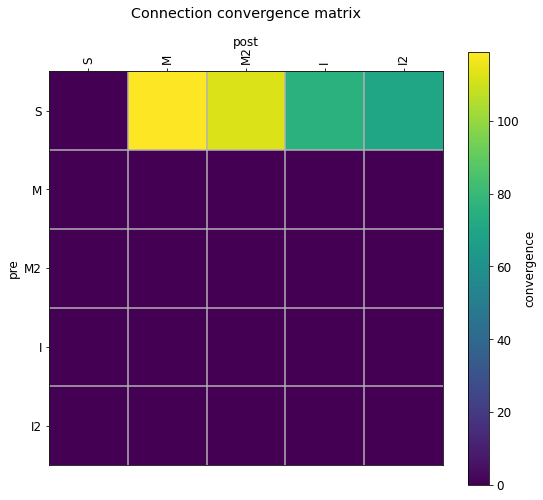

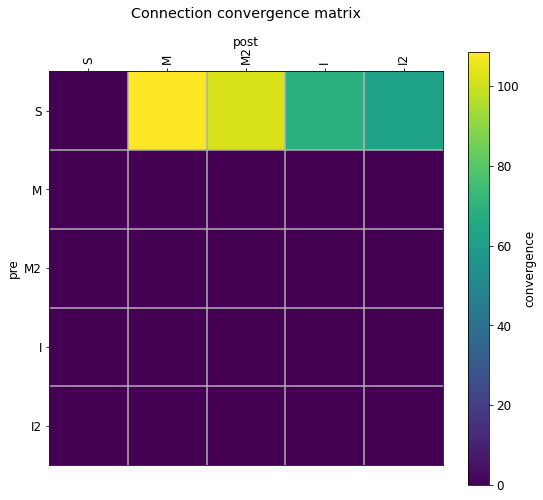

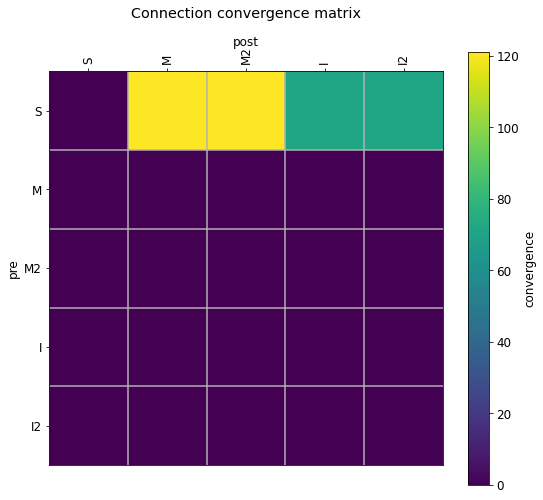

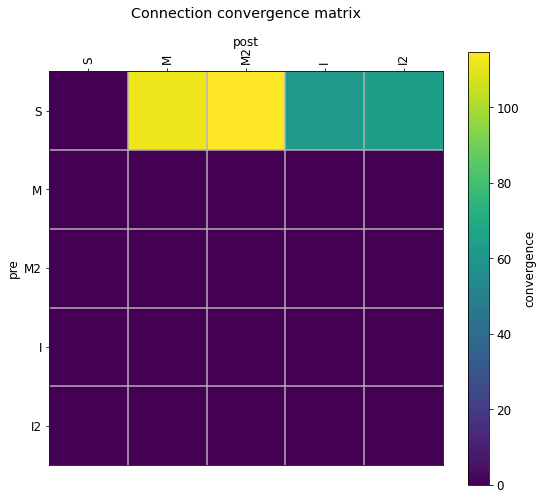

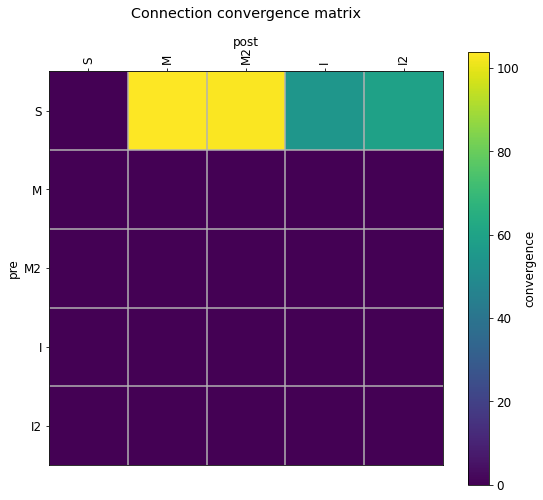

In [4]:
vec_conv = {}
for VPMpercent in [15,25,50,100]:
  for synapsesperconnection_Th_S1 in range(9,10):
    vec_conv[VPMpercent] = {}
    for radius2D_Th_S1 in [25,50,75]:

      VPMnumber = int(0.01*VPMpercent*839.72)
      ## Population parameters
      netParams.popParams['S'] = {'cellType': 'PYR', 'numCells': VPMnumber, 'cellModel': 'HH', 'yRange': [ymin['VPM_sTC'], ymax['VPM_sTC']]}


      ## Cell connectivity rules
      print('\n ###################### \n')
      print('VPMpercent',VPMpercent,'radius2D_Th_S1',radius2D_Th_S1)
      print('\n ###################### \n')

      for post in ['M', 'M2', 'I', 'I2']:
        if post[0] == 'M':
          conn_convergence = 131/synapsesperconnection_Th_S1
        else:
          conn_convergence = 77/synapsesperconnection_Th_S1

        prob_conv = 1.0*(conn_convergence/VPMnumber)*((150.0*150.0)/(radius2D_Th_S1*radius2D_Th_S1)) # prob*(AreaS1/Area_Th_syn)  
        probability_rule = '%f if dist_2D < %f else 0.0' % (prob_conv,radius2D_Th_S1)

        netParams.connParams['EE_S'+'_'+post] = { 
            'preConds': {'pop': 'S'}, 
            'postConds': {'pop': post},
            'probability': probability_rule, 
            'weight': 0.720,  
            'delay': 'defaultDelay+dist_3D/propVelocity',
            'synsPerConn': int(synapsesperconnection_Th_S1)}  

      sim.initialize(netParams = netParams, simConfig = simConfig);  				# create network object and set cfg and net params
      sim.net.createPops();
      sim.net.createCells();
      sim.net.connectCells();
      sim.gatherData(); 
      vvvaaa = sim.analysis.plotConn(feature='convergence', showFig=False);
      vec_conv[VPMpercent][radius2D_Th_S1] = vvvaaa[1]['connMatrix'][0][1:]

In [5]:
vec_conv

{15: {25: array([28.29807692, 28.33687003, 27.        , 27.9       ]),
  50: array([103.78846154, 103.05835544,  72.64285714,  67.14      ]),
  75: array([102.80769231,  98.43899204,  64.28571429,  58.05      ])},
 25: {25: array([49.41346154, 49.27320955, 61.07142857, 51.12      ]),
  50: array([113.01923077, 114.01591512,  64.92857143,  64.35      ]),
  75: array([103.61538462, 103.5       ,  68.78571429,  60.39      ])},
 50: {25: array([102.14423077,  96.0397878 ,  82.28571429,  71.28      ]),
  50: array([119.04807692, 112.73872679,  75.85714286,  70.29      ]),
  75: array([108.66346154, 101.94827586,  69.42857143,  63.18      ])},
 100: {25: array([121.21153846, 121.1061008 ,  71.35714286,  71.91      ]),
  50: array([111.89423077, 114.76790451,  61.71428571,  63.99      ]),
  75: array([103.96153846, 103.17771883,  54.64285714,  59.58      ])}}

In [20]:
# VPMnumber = int(VPMpercent*839.72)
# ['S'] 'numCells': VPMnumber
# ['M'] 'numCells': 312 # conv 131
# ['M2'] 'numCells': 754 # conv 131
# ['I'] 'numCells': 14 # conv 77
# ['I2'] 'numCells': 100 # conv 77

# [VPMpercent][radius2D_Th_S1] = convergence{Thal -> ('M', 'M2', 'I', 'I2')}
#     {15: {25: array([28.29807692, 28.33687003, 27.        , 27.9       ]),
#       50: array([103.78846154, 103.05835544,  72.64285714,  67.14      ]),
#       75: array([102.80769231,  98.43899204,  64.28571429,  58.05      ])},
#      25: {25: array([49.41346154, 49.27320955, 61.07142857, 51.12      ]),
#       50: array([113.01923077, 114.01591512,  64.92857143,  64.35      ]),
#       75: array([103.61538462, 103.5       ,  68.78571429,  60.39      ])},
#      50: {25: array([102.14423077,  96.0397878 ,  82.28571429,  71.28      ]),
#       50: array([119.04807692, 112.73872679,  75.85714286,  70.29      ]),
#       75: array([108.66346154, 101.94827586,  69.42857143,  63.18      ])},
#      100: {25: array([121.21153846, 121.1061008 ,  71.35714286,  71.91      ]),
#       50: array([111.89423077, 114.76790451,  61.71428571,  63.99      ]),
#       75: array([103.96153846, 103.17771883,  54.64285714,  59.58      ])}}

# The Best are:
#     100: {25: array([121.21153846, 121.1061008 ,  71.35714286,  71.91      ])
#     100: {50: array([111.89423077, 114.76790451,  61.71428571,  63.99      ]),
#      50: {50: array([119.04807692, 112.73872679,  75.85714286,  70.29      ]),
#     15: {50: array([103.78846154, 103.05835544,  72.64285714,  67.14      ]),


In [6]:
int(0.15*839.72)

125

In [7]:
post

'I2'

## Full and Radius = 25 um

In [8]:
VPMpercent = 100
synapsesperconnection_Th_S1 = 9
radius2D_Th_S1= 25

VPMnumber = int(0.01*VPMpercent*839.72)
## Population parameters
netParams.popParams['S'] = {'cellType': 'PYR', 'numCells': VPMnumber, 'cellModel': 'HH', 'yRange': [ymin['VPM_sTC'], ymax['VPM_sTC']]}
for post in ['M', 'M2', 'I', 'I2']:
  if post[0] == 'M':
    conn_convergence = 131/synapsesperconnection_Th_S1
  else:
    conn_convergence = 77/synapsesperconnection_Th_S1

  prob_conv = 1.0*(conn_convergence/VPMnumber)*((150.0*150.0)/(radius2D_Th_S1*radius2D_Th_S1)) # prob*(AreaS1/Area_Th_syn)  
  probability_rule = '%f if dist_2D < %f else 0.0' % (prob_conv,radius2D_Th_S1)

  netParams.connParams['EE_S'+'_'+post] = { 
              'preConds': {'pop': 'S'}, 
              'postConds': {'pop': post},
              'probability': probability_rule, 
              'weight': 0.720,  
              'delay': 'defaultDelay+dist_3D/propVelocity',
              'synsPerConn': int(synapsesperconnection_Th_S1)}  

sim.initialize(netParams = netParams, simConfig = simConfig);  				# create network object and set cfg and net params
sim.net.createPops();
sim.net.createCells();
sim.net.connectCells();
sim.gatherData(); 


Start time:  2021-06-15 13:54:03.412031

Creating network of 5 cell populations on 1 hosts...
  Number of cells on node 0: 2019 
  Done; cell creation time = 0.14 s.
Making connections...
  Number of connections on node 0: 15258 
  Number of synaptic contacts on node 0: 137322 
  Done; cell connection time = 9.48 s.

Gathering data...
  Done; gather time = 3.06 s.

Analyzing...
  Cells: 2019
  Connections: 15258 (7.56 per cell)
  Synaptic contacts: 137322 (68.01 per cell)


Plotting 2D representation of network cell locations and connections...


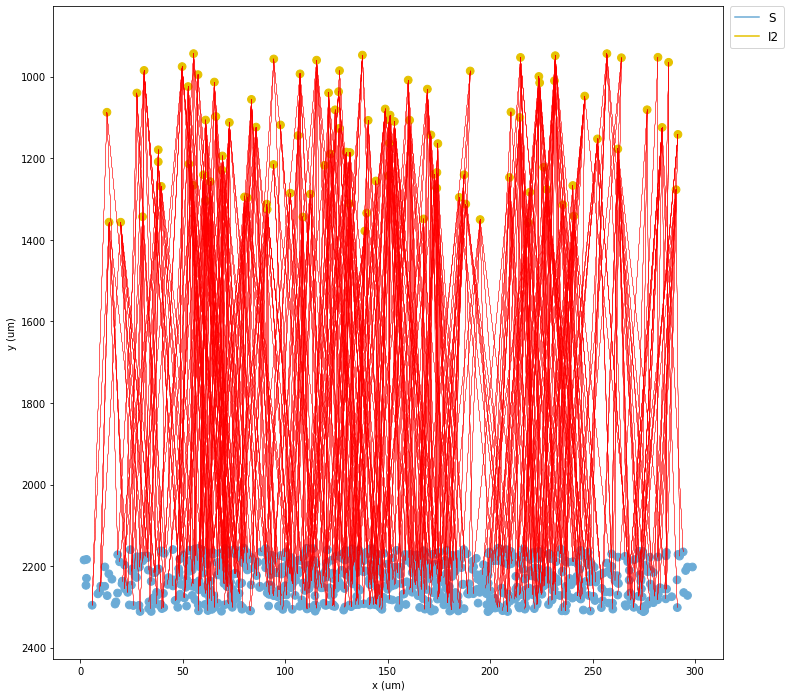

Plotting 2D representation of network cell locations and connections...


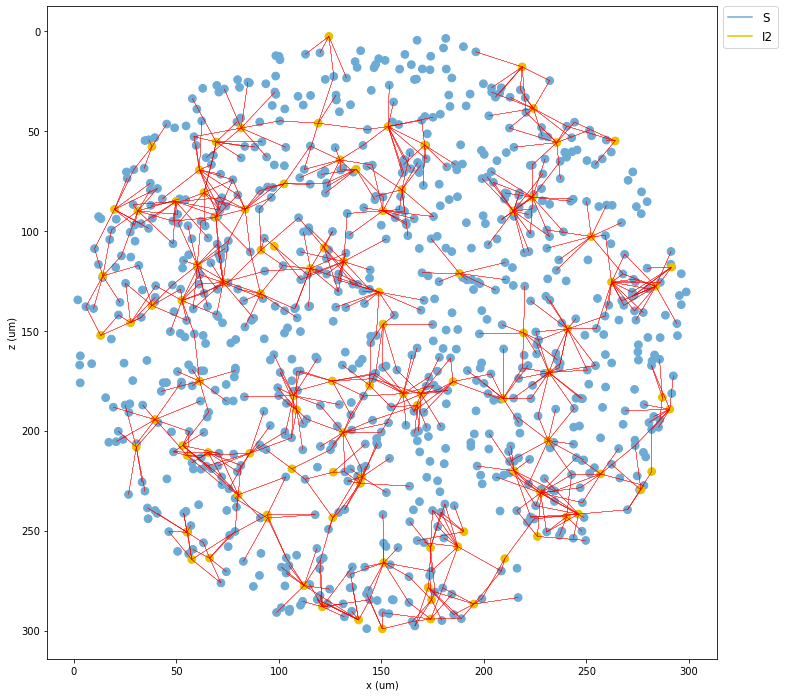

In [9]:
%matplotlib inline
sim.analysis.plot2Dnet(include=['S','I2'], view='xy', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=['S','I2'], view='xz', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);

Plotting 2D representation of network cell locations and connections...


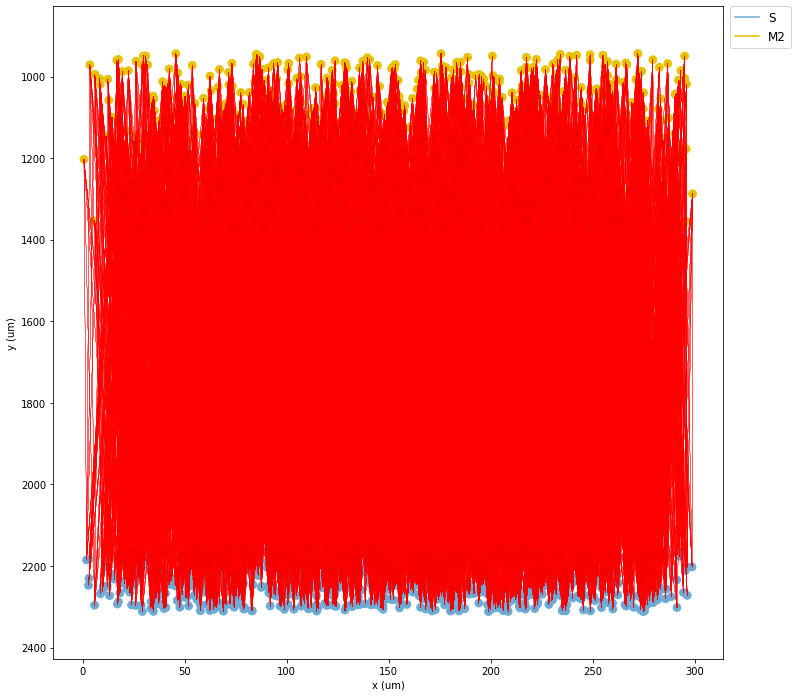

Plotting 2D representation of network cell locations and connections...


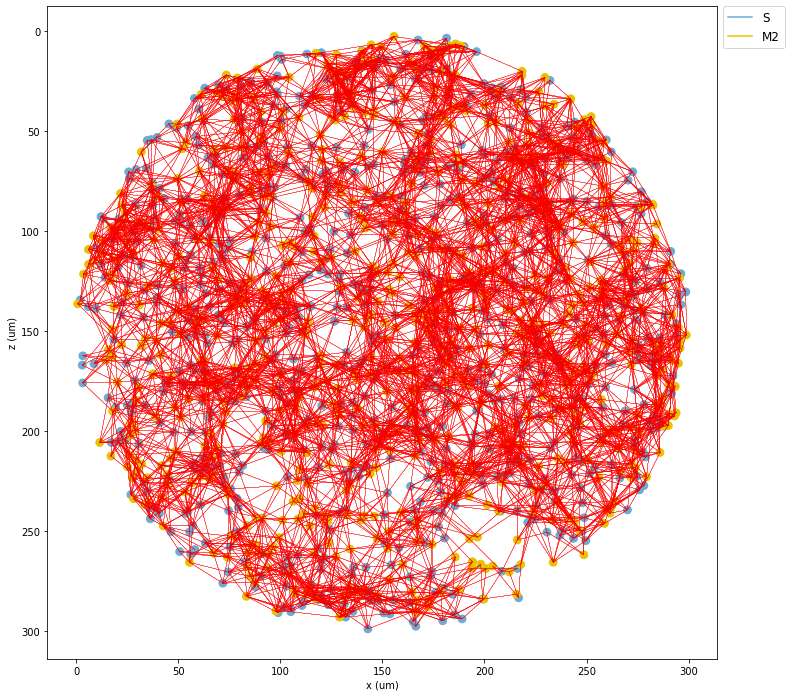

In [10]:
%matplotlib inline
sim.analysis.plot2Dnet(include=['S','M2'], view='xy', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=['S','M2'], view='xz', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);

## 15 % -> 125 VPM cells

In [11]:
VPMpercent = 15
synapsesperconnection_Th_S1 = 9
radius2D_Th_S1= 25

VPMnumber = int(0.01*VPMpercent*839.72)
## Population parameters
netParams.popParams['S'] = {'cellType': 'PYR', 'numCells': VPMnumber, 'cellModel': 'HH', 'yRange': [ymin['VPM_sTC'], ymax['VPM_sTC']]}
for post in ['M', 'M2', 'I', 'I2']:
  if post[0] == 'M':
    conn_convergence = 131/synapsesperconnection_Th_S1
  else:
    conn_convergence = 77/synapsesperconnection_Th_S1

  prob_conv = 1.0*(conn_convergence/VPMnumber)*((150.0*150.0)/(radius2D_Th_S1*radius2D_Th_S1)) # prob*(AreaS1/Area_Th_syn)  
  probability_rule = '%f if dist_2D < %f else 0.0' % (prob_conv,radius2D_Th_S1)

  netParams.connParams['EE_S'+'_'+post] = { 
              'preConds': {'pop': 'S'}, 
              'postConds': {'pop': post},
              'probability': probability_rule, 
              'weight': 0.720,  
              'delay': 'defaultDelay+dist_3D/propVelocity',
              'synsPerConn': int(synapsesperconnection_Th_S1)}  

sim.initialize(netParams = netParams, simConfig = simConfig);  				# create network object and set cfg and net params
sim.net.createPops();
sim.net.createCells();
sim.net.connectCells();
sim.gatherData(); 


Start time:  2021-06-15 13:57:04.589110

Creating network of 5 cell populations on 1 hosts...
  Number of cells on node 0: 1305 
  Done; cell creation time = 0.09 s.
Making connections...
  Number of connections on node 0: 3707 
  Number of synaptic contacts on node 0: 33363 
  Done; cell connection time = 1.78 s.

Gathering data...
  Done; gather time = 0.75 s.

Analyzing...
  Cells: 1305
  Connections: 3707 (2.84 per cell)
  Synaptic contacts: 33363 (25.57 per cell)


Plotting 2D representation of network cell locations and connections...


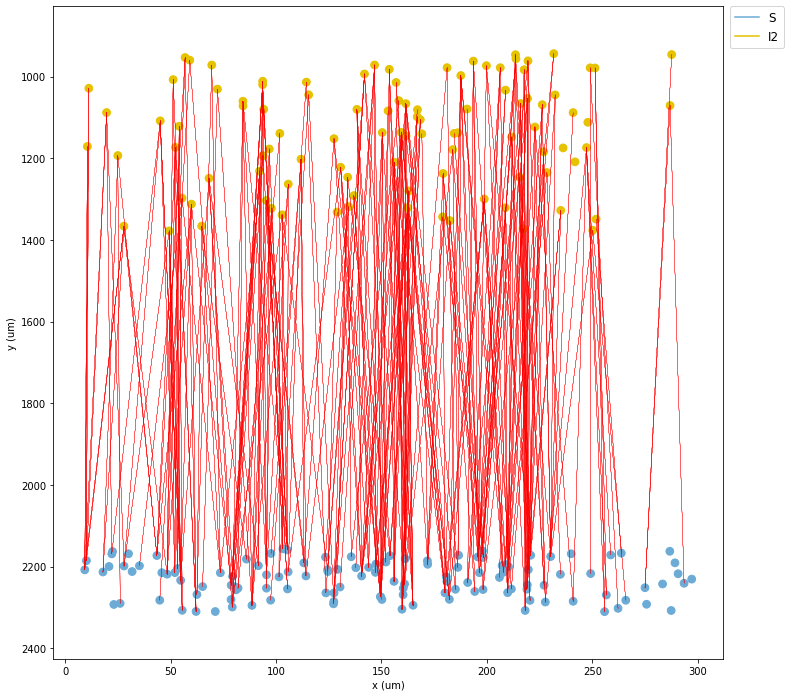

Plotting 2D representation of network cell locations and connections...


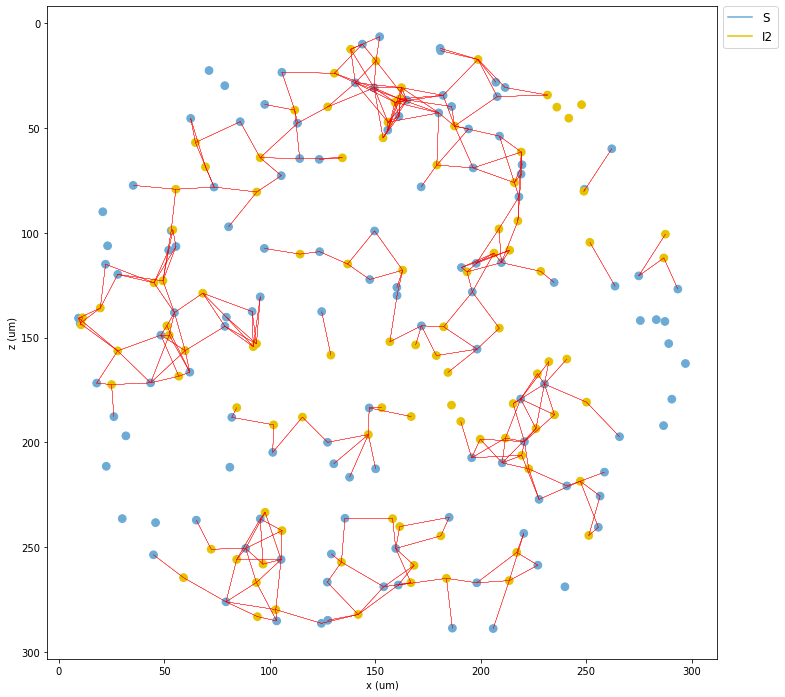

In [12]:
%matplotlib inline
sim.analysis.plot2Dnet(include=['S','I2'], view='xy', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=['S','I2'], view='xz', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);

Plotting 2D representation of network cell locations and connections...


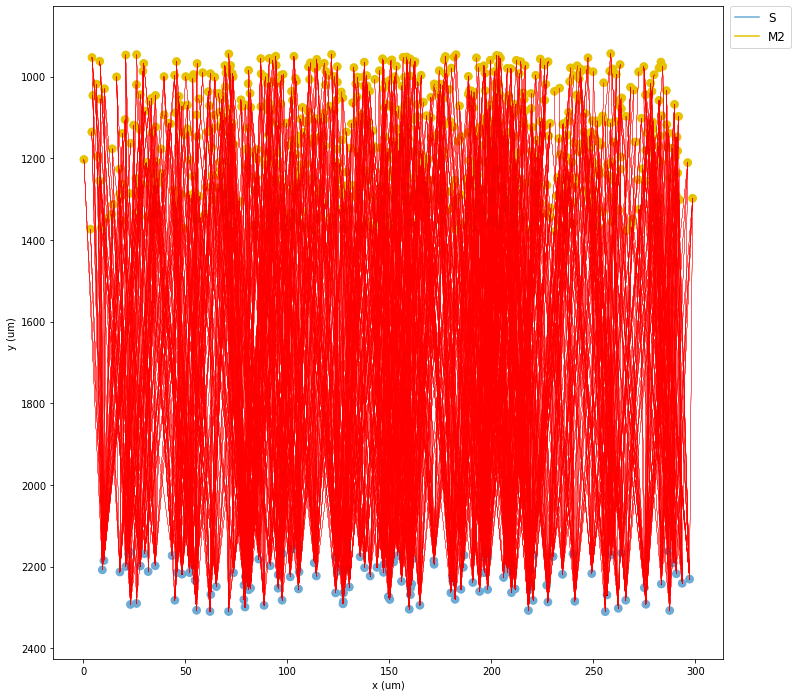

Plotting 2D representation of network cell locations and connections...


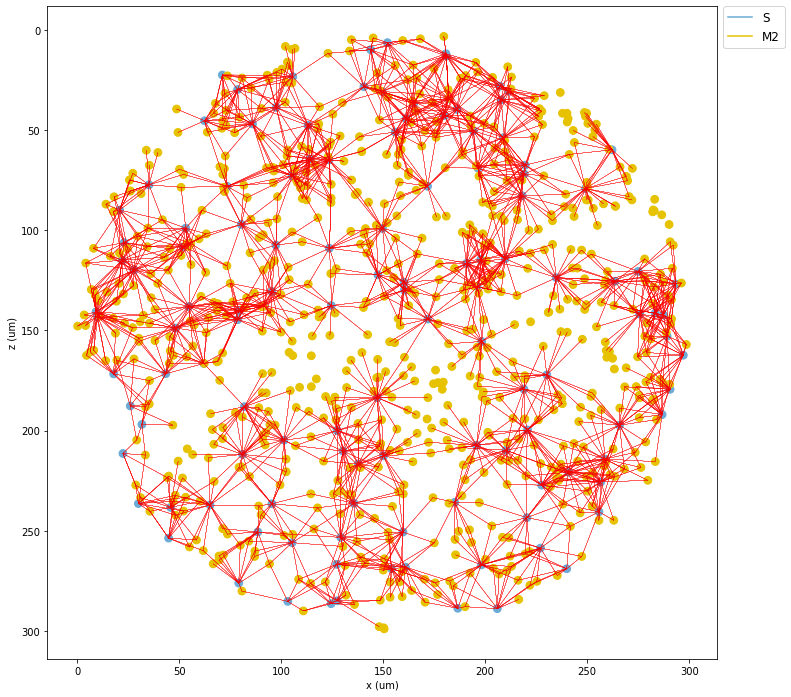

In [13]:
%matplotlib inline
sim.analysis.plot2Dnet(include=['S','M2'], view='xy', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=['S','M2'], view='xz', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);

Plotting connectivity matrix...


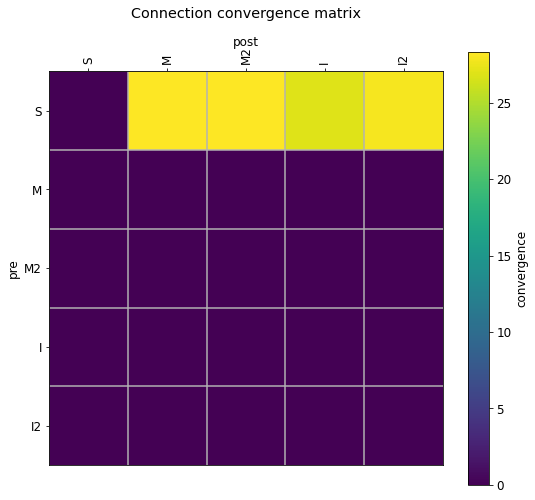

In [14]:
vvvaaa = sim.analysis.plotConn(feature='convergence', showFig=False);
vec_conv[VPMpercent][radius2D_Th_S1] = vvvaaa[1]['connMatrix'][0][1:]

In [15]:
vvvaaa[1]['connMatrix'][0][1:]

array([28.29807692, 28.33687003, 27.        , 27.9       ])

## 15 % -> 125 VPM cells with Radius=50

In [16]:
VPMpercent = 15
synapsesperconnection_Th_S1 = 9
radius2D_Th_S1= 50

VPMnumber = int(0.01*VPMpercent*839.72)
## Population parameters
netParams.popParams['S'] = {'cellType': 'PYR', 'numCells': VPMnumber, 'cellModel': 'HH', 'yRange': [ymin['VPM_sTC'], ymax['VPM_sTC']]}
for post in ['M', 'M2', 'I', 'I2']:
  if post[0] == 'M':
    conn_convergence = 131/synapsesperconnection_Th_S1
  else:
    conn_convergence = 77/synapsesperconnection_Th_S1

  prob_conv = 1.0*(conn_convergence/VPMnumber)*((150.0*150.0)/(radius2D_Th_S1*radius2D_Th_S1)) # prob*(AreaS1/Area_Th_syn)  
  probability_rule = '%f if dist_2D < %f else 0.0' % (prob_conv,radius2D_Th_S1)

  netParams.connParams['EE_S'+'_'+post] = { 
              'preConds': {'pop': 'S'}, 
              'postConds': {'pop': post},
              'probability': probability_rule, 
              'weight': 0.720,  
              'delay': 'defaultDelay+dist_3D/propVelocity',
              'synsPerConn': int(synapsesperconnection_Th_S1)}  

sim.initialize(netParams = netParams, simConfig = simConfig);  				# create network object and set cfg and net params
sim.net.createPops();
sim.net.createCells();
sim.net.connectCells();
sim.gatherData(); 


Start time:  2021-06-15 13:57:49.261363

Creating network of 5 cell populations on 1 hosts...
  Number of cells on node 0: 1305 
  Done; cell creation time = 0.09 s.
Making connections...
  Number of connections on node 0: 13091 
  Number of synaptic contacts on node 0: 117819 
  Done; cell connection time = 4.51 s.

Gathering data...
  Done; gather time = 3.21 s.

Analyzing...
  Cells: 1305
  Connections: 13091 (10.03 per cell)
  Synaptic contacts: 117819 (90.28 per cell)


Plotting 2D representation of network cell locations and connections...


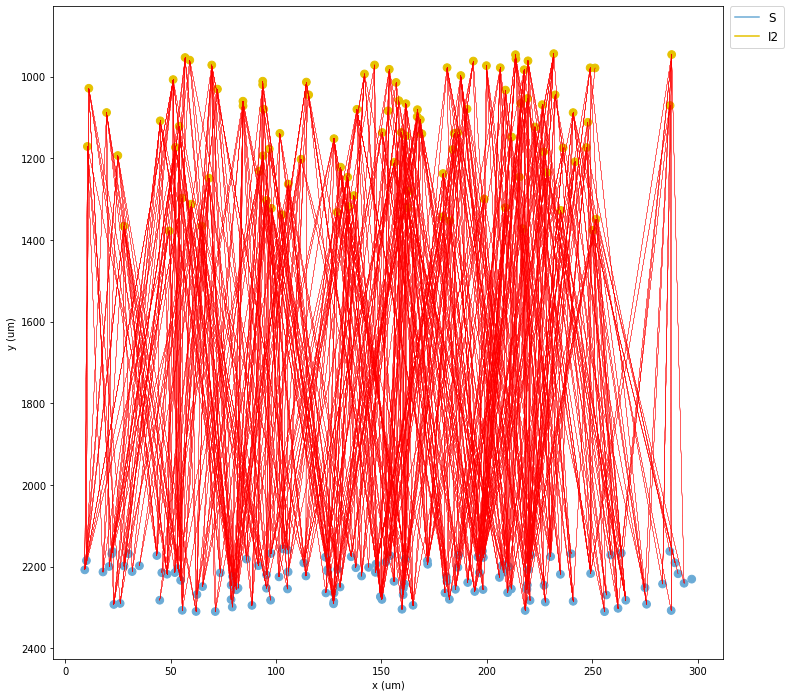

Plotting 2D representation of network cell locations and connections...


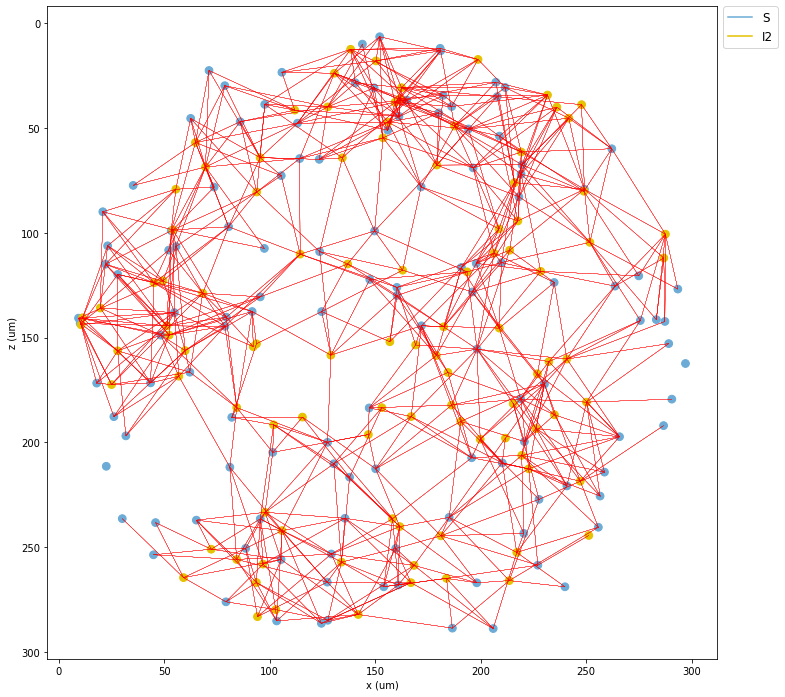

In [17]:
%matplotlib inline
sim.analysis.plot2Dnet(include=['S','I2'], view='xy', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=['S','I2'], view='xz', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);

Plotting 2D representation of network cell locations and connections...


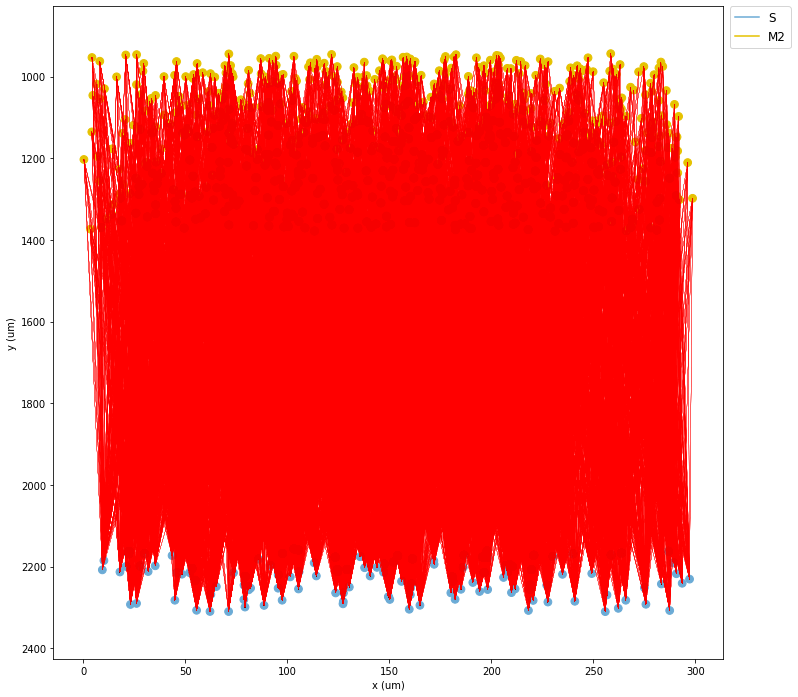

Plotting 2D representation of network cell locations and connections...


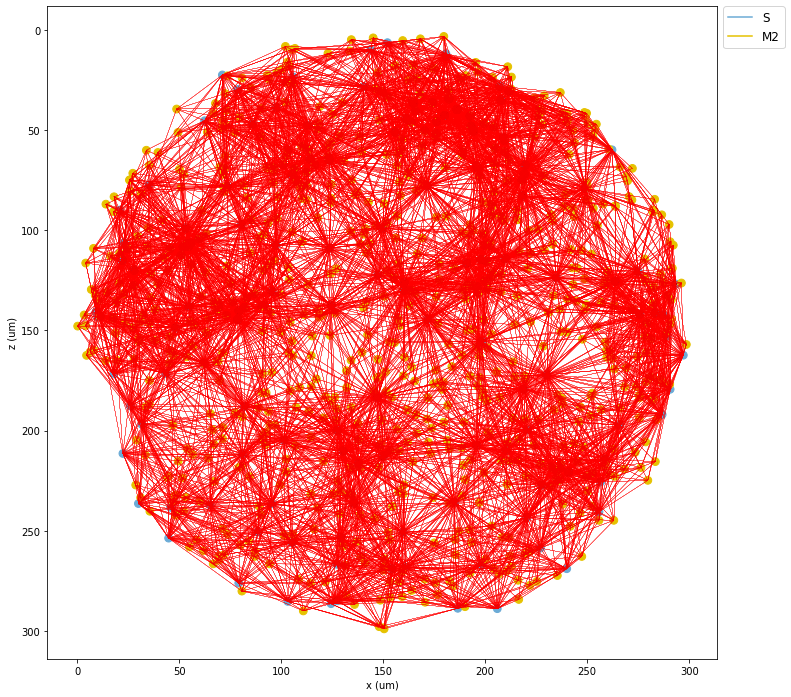

In [18]:
sim.analysis.plot2Dnet(include=['S','M2'], view='xy', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=['S','M2'], view='xz', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, saveFig=None, showFig=True, lineWidth=0.1);

Plotting connectivity matrix...


array([103.78846154, 103.05835544,  72.64285714,  67.14      ])

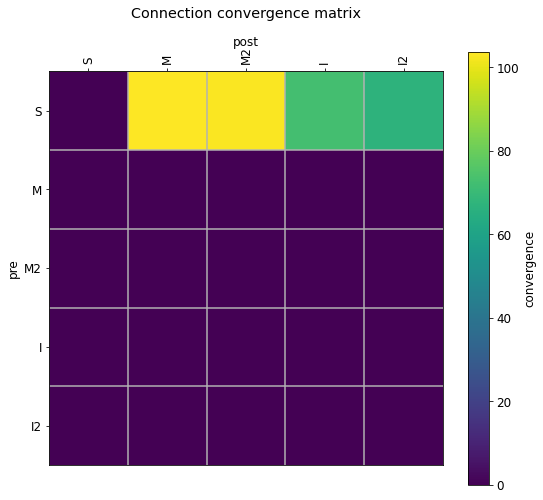

In [19]:
vvvaaa = sim.analysis.plotConn(feature='convergence', showFig=False);
vvvaaa[1]['connMatrix'][0][1:]

In [ ]:
VPL_den_radius = 49.1
VPM_den_radius = 73.3
POm_den_radius = 75.4